In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [37]:
data = pd.read_csv('Sales Data.csv')
data.head()

,order_id,user_id,created_at,discount_cost,discount_type,basket
0,1,1,4/12/2021,10000,1.0,12000
1,2,2,5/9/2021,0,NaN,20000
2,3,3,5/9/2021,10000,1.0,14000
3,4,4,11/10/2021,0,NaN,15000
4,5,5,11/10/2021,10000,1.0,16000


In [38]:
data['discount_type'].fillna(0, inplace=True)

In [39]:
data['created_at'] = pd.to_datetime(data['created_at'])
data.head()

,order_id,user_id,created_at,discount_cost,discount_type,basket
0,1,1,2021-04-12,10000,1.0,12000
1,2,2,2021-05-09,0,0.0,20000
2,3,3,2021-05-09,10000,1.0,14000
3,4,4,2021-11-10,0,0.0,15000
4,5,5,2021-11-10,10000,1.0,16000


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29057 entries, 0 to 29056
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       29057 non-null  int64         
 1   user_id        29057 non-null  int64         
 2   created_at     29057 non-null  datetime64[ns]
 3   discount_cost  29057 non-null  int64         
 4   discount_type  29057 non-null  float64       
 5   basket         29057 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 1.3 MB


In [41]:
last_day = data['created_at'].max()
last_day

Timestamp('2022-07-31 00:00:00')

In [42]:
goal_day = last_day + dt.timedelta(days=1)
pd.to_datetime(goal_day)
goal_day

Timestamp('2022-08-01 00:00:00')

In [43]:
rfm = data.groupby('user_id').agg({
    'created_at' : lambda date: (goal_day - date.max()).days,
    'order_id' : lambda num: len(num),
    'basket' : lambda price: price.sum()
})

In [44]:
rfm.head()

,created_at,order_id,basket
user_id,,,
1,84,4,30200
2,58,2,61000
3,14,4,63500
4,114,3,69600
5,195,2,31500


In [45]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [46]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9985 entries, 1 to 9985
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   recency    9985 non-null   int64
 1   frequency  9985 non-null   int64
 2   monetary   9985 non-null   int64
dtypes: int64(3)
memory usage: 312.0 KB


In [47]:
rfm.columns

Index(['recency', 'frequency', 'monetary'], dtype='object')

In [48]:
rfm['recency'] = rfm['recency'].astype('int')

In [49]:
rfm.head()

,recency,frequency,monetary
user_id,,,
1,84,4,30200
2,58,2,61000
3,14,4,63500
4,114,3,69600
5,195,2,31500


In [50]:
rfm["R"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])
rfm["F"] = pd.qcut(rfm["frequency"].rank(method='first'),5,labels=[1,2,3,4,5])
rfm["M"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

In [51]:
rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score
user_id,,,,,,,
1,84,4,30200,2,4,3,243
2,58,2,61000,3,3,4,334
3,14,4,63500,5,4,4,544
4,114,3,69600,2,4,4,244
5,195,2,31500,1,3,3,133


In [52]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [53]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score,Segment
user_id,,,,,,,,
1,84,4,30200,2,4,3,243,At Risk
2,58,2,61000,3,3,4,334,Need Attention
3,14,4,63500,5,4,4,544,Champions
4,114,3,69600,2,4,4,244,At Risk
5,195,2,31500,1,3,3,133,At Risk


In [54]:
rfm = rfm.reset_index()
rfm.head()

,user_id,recency,frequency,monetary,R,F,M,RFM_Score,Segment
0,1,84,4,30200,2,4,3,243,At Risk
1,2,58,2,61000,3,3,4,334,Need Attention
2,3,14,4,63500,5,4,4,544,Champions
3,4,114,3,69600,2,4,4,244,At Risk
4,5,195,2,31500,1,3,3,133,At Risk


In [55]:
rfm = rfm[['user_id','RFM_Score', 'Segment']]
rfm.head()

,user_id,RFM_Score,Segment
0,1,243,At Risk
1,2,334,Need Attention
2,3,544,Champions
3,4,244,At Risk
4,5,133,At Risk


In [56]:
dataframe = data.merge(rfm, how='inner', on='user_id')
dataframe.head()

,order_id,user_id,created_at,discount_cost,discount_type,basket,RFM_Score,Segment
0,1,1,2021-04-12,10000,1.0,12000,243,At Risk
1,7704,1,2022-03-28,0,0.0,6400,243,At Risk
2,7981,1,2022-03-31,0,0.0,5000,243,At Risk
3,13985,1,2022-05-09,0,0.0,6800,243,At Risk
4,2,2,2021-05-09,0,0.0,20000,334,Need Attention


In [57]:
df_discount = dataframe.groupby('user_id')['created_at'].min()
df_discount

user_id
1      2021-04-12
2      2021-05-09
3      2021-05-09
4      2021-11-10
5      2021-11-10
          ...    
9981   2022-07-31
9982   2022-07-31
9983   2022-07-31
9984   2022-07-31
9985   2022-07-31
Name: created_at, Length: 9985, dtype: datetime64[ns]

In [58]:
df_discount = df_discount.reset_index()
df_discount.head()

,user_id,created_at
0,1,2021-04-12
1,2,2021-05-09
2,3,2021-05-09
3,4,2021-11-10
4,5,2021-11-10


In [59]:
discount_type = dataframe[['user_id', 'created_at', 'discount_type', 'Segment']].merge(df_discount, how='inner', on=['user_id', 'created_at'])
discount_type.head()

,user_id,created_at,discount_type,Segment
0,1,2021-04-12,1.0,At Risk
1,2,2021-05-09,0.0,Need Attention
2,3,2021-05-09,1.0,Champions
3,4,2021-11-10,0.0,At Risk
4,5,2021-11-10,1.0,At Risk


In [60]:
dataframe.loc[dataframe['discount_type'] == 0, 'discount_use'] = 'not used'
dataframe.loc[dataframe['discount_type'] != 0, 'discount_use'] = 'used'
dataframe.head()

,order_id,user_id,created_at,discount_cost,discount_type,basket,RFM_Score,Segment,discount_use
0,1,1,2021-04-12,10000,1.0,12000,243,At Risk,used
1,7704,1,2022-03-28,0,0.0,6400,243,At Risk,not used
2,7981,1,2022-03-31,0,0.0,5000,243,At Risk,not used
3,13985,1,2022-05-09,0,0.0,6800,243,At Risk,not used
4,2,2,2021-05-09,0,0.0,20000,334,Need Attention,not used
...,...,...,...,...,...,...,...,...,...
29052,29031,9981,2022-07-31,10000,1.0,24000,533,Potential Loyalists,used
29053,29034,9982,2022-07-31,0,0.0,30000,533,Potential Loyalists,not used
29054,29036,9983,2022-07-31,0,0.0,21000,532,Potential Loyalists,not used
29055,29039,9984,2022-07-31,0,0.0,22000,532,Potential Loyalists,not used


In [61]:
discount_use = dataframe[['user_id', 'created_at', 'discount_use', 'Segment']].merge(df_discount, how='inner', on=['user_id', 'created_at'])
discount_use.head()

,user_id,created_at,discount_use,Segment
0,1,2021-04-12,used,At Risk
1,2,2021-05-09,not used,Need Attention
2,3,2021-05-09,used,Champions
3,4,2021-11-10,not used,At Risk
4,5,2021-11-10,used,At Risk
...,...,...,...,...
10094,9981,2022-07-31,used,Potential Loyalists
10095,9982,2022-07-31,not used,Potential Loyalists
10096,9983,2022-07-31,not used,Potential Loyalists
10097,9984,2022-07-31,not used,Potential Loyalists


C:\Users\Joker\AppData\Local\Temp\ipykernel_20300\2591547435.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  discount_type.groupby(["discount_type", "Segment"]).size().unstack(level=0, fill_value=True).apply(lambda x: x / sum(x), axis=0).plot(ax=ax, kind='bar', subplots=True, rot=90, sharey=True, layout=(2, 3))


array([[<AxesSubplot:title={'center':'0.0'}, xlabel='Segment'>,
        <AxesSubplot:title={'center':'1.0'}, xlabel='Segment'>,
        <AxesSubplot:title={'center':'2.0'}, xlabel='Segment'>],
       [<AxesSubplot:xlabel='Segment'>, <AxesSubplot:xlabel='Segment'>,
        <AxesSubplot:xlabel='Segment'>]], dtype=object)

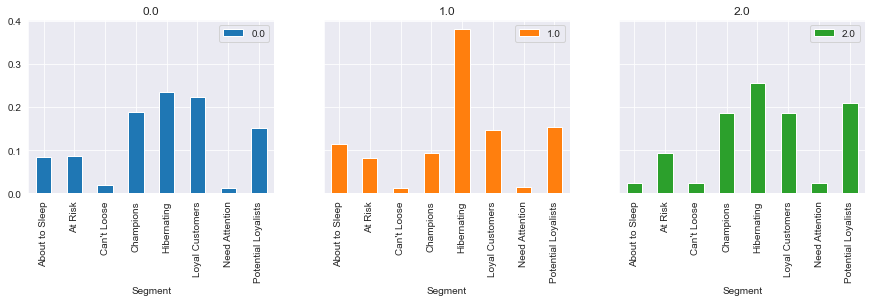

In [62]:
fig, ax = plt.subplots(figsize=(15, 7))
discount_type.groupby(["discount_type", "Segment"]).size().unstack(level=0, fill_value=True).apply(lambda x: x / sum(x), axis=0).plot(ax=ax, kind='bar', subplots=True, rot=90, sharey=True, layout=(2, 3))

C:\Users\Joker\AppData\Local\Temp\ipykernel_20300\48259952.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  discount_use.groupby(['discount_use', 'Segment']).size().unstack(level=0, fill_value=True).apply(lambda x: x , axis=0).plot(ax=ax1, kind='bar', subplots=True, rot=90, sharey=True, layout=(2, 2))


array([[<AxesSubplot:title={'center':'not used'}, xlabel='Segment'>,
        <AxesSubplot:title={'center':'used'}, xlabel='Segment'>],
       [<AxesSubplot:xlabel='Segment'>, <AxesSubplot:xlabel='Segment'>]],
      dtype=object)

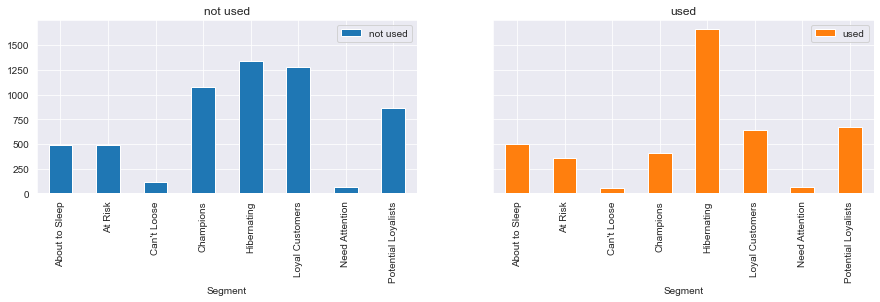

In [63]:
fig1, ax1 = plt.subplots(figsize=(15, 7))
discount_use.groupby(['discount_use', 'Segment']).size().unstack(level=0, fill_value=True).apply(lambda x: x , axis=0).plot(ax=ax1, kind='bar', subplots=True, rot=90, sharey=True, layout=(2, 2))